In [2]:
from __future__ import division

import argparse, time, logging, random, math

import numpy as np
import mxnet as mx

from mxnet import gluon, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

from gluoncv.model_zoo import get_model
from gluoncv.utils import makedirs, TrainingHistory
from gluoncv.data import transforms as gcv_transforms
print("Imports successful")

Imports successful


In [3]:
# number of GPUs to use
num_gpus = 1
ctx = [mx.gpu(i) for i in range(num_gpus)]

# Get the model CIFAR_ResNet20_v1, with 10 output classes, without pre-trained weights
#net = get_model('cifar_resnet20_v1', classes=10)
net = get_model('ResNet50_v2', classes=10)
net.initialize(mx.init.Xavier(), ctx = ctx)
print("Model Init Done.")

Model Init Done.


In [4]:
transform_train = transforms.Compose([
    # Randomly crop an area and resize it to be 32x32, then pad it to be 40x40
    gcv_transforms.RandomCrop(32, pad=4),
    # Randomly flip the image horizontally
    transforms.RandomFlipLeftRight(),
    # Transpose the image from height*width*num_channels to num_channels*height*width
    # and map values from [0, 255] to [0,1]
    transforms.ToTensor(),
    # Normalize the image with mean and standard deviation calculated across all images
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
])

In [5]:
# Batch Size for Each GPU
per_device_batch_size = 128
# Number of data loader workers
num_workers = 8
# Calculate effective total batch size
batch_size = per_device_batch_size * num_gpus

# Set train=True for training data
# Set shuffle=True to shuffle the training data
train_data = gluon.data.DataLoader(
    gluon.data.vision.CIFAR10(train=True).transform_first(transform_train),
    batch_size=batch_size, shuffle=True, last_batch='discard', num_workers=num_workers)

# Set train=False for validation data
val_data = gluon.data.DataLoader(
    gluon.data.vision.CIFAR10(train=False).transform_first(transform_test),
    batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [6]:
# Learning rate decay factor
lr_decay = 0.1
# Epochs where learning rate decays
lr_decay_epoch = [80, 160, np.inf]

# Nesterov accelerated gradient descent
optimizer = 'nag'
# Set parameters
optimizer_params = {'learning_rate': 0.1, 'wd': 0.0001, 'momentum': 0.9}

# Define our trainer for net
trainer = gluon.Trainer(net.collect_params(), optimizer, optimizer_params)

In [10]:
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

In [11]:
train_metric = mx.metric.Accuracy()
train_history = TrainingHistory(['training-error', 'validation-error'])

In [12]:
def test(ctx, val_data):
    metric = mx.metric.Accuracy()
    for i, batch in enumerate(val_data):
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0)
        outputs = [net(X) for X in data]
        metric.update(label, outputs)
    return metric.get()

[Epoch 0] train=0.767428 val=0.738800 loss=33607.867222 time: 16.096704
[Epoch 1] train=0.787800 val=0.795400 loss=30360.378284 time: 16.108787
[Epoch 2] train=0.805589 val=0.768500 loss=28007.304749 time: 16.030437
[Epoch 3] train=0.818790 val=0.796200 loss=26165.128380 time: 16.034077
[Epoch 4] train=0.826362 val=0.809300 loss=24844.467133 time: 16.104359
[Epoch 5] train=0.836338 val=0.798100 loss=23512.778351 time: 16.008881
[Epoch 6] train=0.844010 val=0.831400 loss=22572.682369 time: 16.041172
[Epoch 7] train=0.850641 val=0.833700 loss=21622.834566 time: 16.152831
[Epoch 8] train=0.854948 val=0.816500 loss=20915.366274 time: 16.123063
[Epoch 9] train=0.859756 val=0.805400 loss=20184.807514 time: 16.130968
[Epoch 10] train=0.862560 val=0.818800 loss=19796.422306 time: 16.249558
[Epoch 11] train=0.868950 val=0.831200 loss=18993.856321 time: 16.116868
[Epoch 12] train=0.870893 val=0.800600 loss=18612.637062 time: 16.112872
[Epoch 13] train=0.871454 val=0.850500 loss=18452.056797 time

[Epoch 113] train=0.986859 val=0.911900 loss=1962.128677 time: 16.267088
[Epoch 114] train=0.987320 val=0.910900 loss=1972.736976 time: 16.364694
[Epoch 115] train=0.988041 val=0.911400 loss=1855.651257 time: 16.322829
[Epoch 116] train=0.987961 val=0.912800 loss=1859.722674 time: 16.288213
[Epoch 117] train=0.987720 val=0.912700 loss=1831.402850 time: 16.168266
[Epoch 118] train=0.988782 val=0.910700 loss=1725.597312 time: 16.252010
[Epoch 119] train=0.987660 val=0.910500 loss=1787.131518 time: 16.208196
[Epoch 120] train=0.989163 val=0.909800 loss=1693.024771 time: 16.269358
[Epoch 121] train=0.988862 val=0.913700 loss=1722.250781 time: 16.165674
[Epoch 122] train=0.988562 val=0.912700 loss=1661.053533 time: 16.231755
[Epoch 123] train=0.988702 val=0.913900 loss=1728.066147 time: 16.205270
[Epoch 124] train=0.989944 val=0.913500 loss=1603.979865 time: 16.147305
[Epoch 125] train=0.988642 val=0.909900 loss=1702.840081 time: 16.248926
[Epoch 126] train=0.989083 val=0.914200 loss=1674.5

[Epoch 227] train=0.997696 val=0.912700 loss=520.242700 time: 16.164641
[Epoch 228] train=0.997496 val=0.914700 loss=543.277616 time: 16.267015
[Epoch 229] train=0.997957 val=0.914200 loss=491.469038 time: 16.302396
[Epoch 230] train=0.997496 val=0.914700 loss=520.648330 time: 16.284395
[Epoch 231] train=0.997736 val=0.915200 loss=521.236540 time: 16.257567
[Epoch 232] train=0.997356 val=0.914900 loss=548.616859 time: 16.230944
[Epoch 233] train=0.997877 val=0.913000 loss=544.982603 time: 16.474244
[Epoch 234] train=0.997796 val=0.912900 loss=491.296718 time: 16.270092
[Epoch 235] train=0.997897 val=0.911500 loss=510.922922 time: 16.351708
[Epoch 236] train=0.997817 val=0.913900 loss=517.657984 time: 16.417597
[Epoch 237] train=0.997877 val=0.914100 loss=508.055361 time: 16.347787
[Epoch 238] train=0.997596 val=0.913800 loss=513.890281 time: 16.491621
[Epoch 239] train=0.998017 val=0.913300 loss=498.409484 time: 16.341497


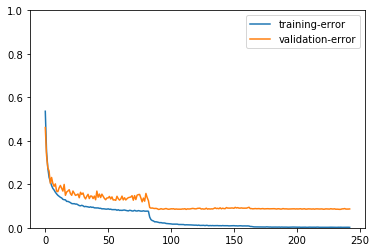

Done.


In [14]:
epochs = 120
lr_decay_count = 0

for epoch in range(epochs):
    tic = time.time()
    train_metric.reset()
    train_loss = 0

    # Learning rate decay
    if epoch == lr_decay_epoch[lr_decay_count]:
        trainer.set_learning_rate(trainer.learning_rate*lr_decay)
        lr_decay_count += 1

    # Loop through each batch of training data
    for i, batch in enumerate(train_data):
        # Extract data and label
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0)

        # AutoGrad
        with ag.record():
            output = [net(X) for X in data]
            loss = [loss_fn(yhat, y) for yhat, y in zip(output, label)]

        # Backpropagation
        for l in loss:
            l.backward()

        # Optimize
        trainer.step(batch_size)

        # Update metrics
        train_loss += sum([l.sum().asscalar() for l in loss])
        train_metric.update(label, output)

    name, acc = train_metric.get()
    # Evaluate on Validation data
    name, val_acc = test(ctx, val_data)

    # Update history and print metrics
    train_history.update([1-acc, 1-val_acc])
    print('[Epoch %d] train=%f val=%f loss=%f time: %f' %
        (epoch, acc, val_acc, train_loss, time.time()-tic))

# We can plot the metric scores with:

train_history.plot()
print("Done.")